

## Text Sentiment Analyzer using Bert pre-trained model

## Project Idea:

   The main idea of the project is to analyze the basic emotions exhibited by a text and classify them as one of six different emotions - anger, disgust, fear, joy, sadness, and surprise using a supervised machine learning algorithm. The text sentiment analyzer combines machine learning with natural language processing. We have trained our model using the dataset that contains 16000+ tweets. The datasets simply have texts and the labels attached to it, as number 0-5.  
Based on these metrics, the model will classify the sentiments of the texts. This can be used in captions/bio in emails, social media sites, etc. to ensure our words match the tone we are expressing.


   ### DataSet: https://huggingface.co/datasets/emotion
   
   ## Annotations of different emotions:
   
   ##### Sadness: 0
   ##### Joy: 1
   ##### Love: 2
   ##### Anger: 3
   ##### Fear: 4
   ##### Surprise:5

In [7]:
!pip install text_hammer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 115 kB 5.2 MB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [9]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 5.2 MB/s 
     |████████████████████████████████| 6.6 MB 44.0 MB/s 
     |████████████████████████████████| 120 kB 44.5 MB/s 


In [11]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
import pandas as pd
import numpy as np
import text_hammer as th
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer,TFBertModel
from transformers import BertTokenizer, TFBertModel, BertConfig,TFDistilBertModel,DistilBertTokenizer,DistilBertConfig
import shutil
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%config Completer.use_jedi = False # if autocompletion doesnot work in kaggle notebook | hit tab

In [14]:
# importing the dataset 
df_train = pd.read_csv('/content/training.csv')
df_test = pd.read_csv('/content/test.csv')
df_val=pd.read_csv('/content/validation.csv')

In [15]:
df_full = pd.concat([df_train,df_test,df_val], axis = 0)
df_full

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
1995,im having ssa examination tomorrow in the morn...,0
1996,i constantly worry about their fight against n...,1
1997,i feel its important to share this info for th...,1
1998,i truly feel that if you are passionate enough...,1


In [16]:
def text_preprocessing(df,col_name):
    column = col_name
    df[column] = df[column].progress_apply(lambda x:str(x).lower())
    df[column] = df[column].progress_apply(lambda x: th.cont_exp(x)) #you're -> you are; i'm -> i am
    df[column] = df[column].progress_apply(lambda x: th.remove_emails(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_html_tags(x))
 
    df[column] = df[column].progress_apply(lambda x: th.remove_special_chars(x))
    df[column] = df[column].progress_apply(lambda x: th.remove_accented_chars(x))
 
    return(df)

In [17]:
df_cleaned = text_preprocessing(df_full,'text')

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

In [18]:
df_cleaned = df_cleaned.copy()

In [19]:
df_cleaned['num_words'] = df_cleaned['text'].apply(lambda x:len(x.split()))

In [20]:
# changing the data type to the category to encode into codes 
df_cleaned['label'] = df_cleaned['label'].astype('category')

In [21]:
df_cleaned['label']

0       0
1       0
2       3
3       2
4       3
       ..
1995    0
1996    1
1997    1
1998    1
1999    1
Name: label, Length: 20000, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [22]:
df_cleaned['label'].cat.codes

0       0
1       0
2       3
3       2
4       3
       ..
1995    0
1996    1
1997    1
1998    1
1999    1
Length: 20000, dtype: int8

In [25]:
encoded_dict  = {'sadness':0,'joy':1, 'love':2, 'anger':3, 'fear':4, 'surprise':5}

In [26]:
df_cleaned.num_words.max()

66

In [27]:
data_train,data_test = train_test_split(df_cleaned, test_size = 0.3, random_state = 42, stratify = df_cleaned['label'])

In [28]:
data_train.shape

(14000, 3)

In [29]:
data_test.shape

(6000, 3)

In [30]:
to_categorical(data_train['label'])

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.]], dtype=float32)

In [31]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [32]:
# for saving model locally and we can load it later on 
tokenizer.save_pretrained('bert-tokenizer')
bert.save_pretrained('bert-model')

In [33]:
shutil.make_archive('bert-tokenizer', 'zip', 'bert-tokenizer')
shutil.make_archive('bert-model','zip','bert-model')

'/content/bert-model.zip'

In [34]:
tokenizer('I will be kaggle grandmaster')

{'input_ids': [101, 146, 1209, 1129, 24181, 25186, 5372, 6532, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [35]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=data_train['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


x_test = tokenizer(
    text=data_test['text'].tolist(),
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [36]:
x_test['input_ids']

<tf.Tensor: shape=(6000, 70), dtype=int32, numpy=
array([[ 101,  178, 1243, ...,    0,    0,    0],
       [ 101,  178, 1631, ...,    0,    0,    0],
       [ 101,  178, 2810, ...,    0,    0,    0],
       ...,
       [ 101,  178, 1838, ...,    0,    0,    0],
       [ 101,  178, 1238, ...,    0,    0,    0],
       [ 101,  178, 4534, ...,    0,    0,    0]], dtype=int32)>

In [37]:
max_len = 70
 
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

embeddings = bert(input_ids,attention_mask = input_mask)[0] #(0 is the last hidden states,1 means pooler_output)
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(6,activation = 'sigmoid')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [38]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy('balanced_accuracy'),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [39]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 70)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 70)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 70,                                            

In [40]:
tf.config.experimental_run_functions_eagerly(True)
tf.config.run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [41]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = to_categorical(data_train['label']),
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, to_categorical(data_test['label'])
    ),
  epochs=1,
    batch_size=36
)

  1/389 [..............................] - ETA: 3:35:41 - loss: 2.0051 - balanced_accuracy: 0.1111

  2/389 [..............................] - ETA: 3:11:48 - loss: 1.8006 - balanced_accuracy: 0.2500

  3/389 [..............................] - ETA: 3:12:06 - loss: 1.7603 - balanced_accuracy: 0.2870

  4/389 [..............................] - ETA: 3:10:32 - loss: 1.7162 - balanced_accuracy: 0.2986

  5/389 [..............................] - ETA: 3:09:26 - loss: 1.6935 - balanced_accuracy: 0.3167

  6/389 [..............................] - ETA: 3:08:29 - loss: 1.6893 - balanced_accuracy: 0.3102

  7/389 [..............................] - ETA: 3:07:58 - loss: 1.7138 - balanced_accuracy: 0.3016

  8/389 [..............................] - ETA: 3:07:28 - loss: 1.7037 - balanced_accuracy: 0.3056

  9/389 [..............................] - ETA: 3:06:42 - loss: 1.7157 - balanced_accuracy: 0.2963

 10/389 [..............................] - ETA: 3:06:06 - loss: 1.7002 - balanced_accuracy: 0.3000

 11/389 [..............................] - ETA: 3:05:26 - loss: 1.6792 - balanced_accuracy: 0.3106

 12/389 [..............................] - ETA: 3:04:50 - loss: 1.6800 - balanced_accuracy: 0.3079

 13/389 [>.............................] - ETA: 3:04:13 - loss: 1.6780 - balanced_accuracy: 0.3034

 14/389 [>.............................] - ETA: 3:03:38 - loss: 1.6717 - balanced_accuracy: 0.3135

 15/389 [>.............................] - ETA: 3:03:04 - loss: 1.6621 - balanced_accuracy: 0.3241

 16/389 [>.............................] - ETA: 3:02:35 - loss: 1.6455 - balanced_accuracy: 0.3299

 17/389 [>.............................] - ETA: 3:02:05 - loss: 1.6265 - balanced_accuracy: 0.3448

 18/389 [>.............................] - ETA: 3:01:42 - loss: 1.6181 - balanced_accuracy: 0.3457

 19/389 [>.............................] - ETA: 3:02:30 - loss: 1.5978 - balanced_accuracy: 0.3626

 20/389 [>.............................] - ETA: 3:02:01 - loss: 1.6000 - balanced_accuracy: 0.3639

 21/389 [>.............................] - ETA: 3:01:33 - loss: 1.5932 - balanced_accuracy: 0.3677

 22/389 [>.............................] - ETA: 3:01:02 - loss: 1.5831 - balanced_accuracy: 0.3750

 23/389 [>.............................] - ETA: 3:00:31 - loss: 1.5705 - balanced_accuracy: 0.3829

 24/389 [>.............................] - ETA: 3:00:01 - loss: 1.5666 - balanced_accuracy: 0.3854

 25/389 [>.............................] - ETA: 2:59:33 - loss: 1.5616 - balanced_accuracy: 0.3889

 26/389 [=>............................] - ETA: 2:59:05 - loss: 1.5548 - balanced_accuracy: 0.3932

 27/389 [=>............................] - ETA: 2:58:33 - loss: 1.5451 - balanced_accuracy: 0.3992

 28/389 [=>............................] - ETA: 2:58:01 - loss: 1.5327 - balanced_accuracy: 0.4038

 29/389 [=>............................] - ETA: 2:57:29 - loss: 1.5245 - balanced_accuracy: 0.4071

 30/389 [=>............................] - ETA: 2:56:56 - loss: 1.5086 - balanced_accuracy: 0.4139

 31/389 [=>............................] - ETA: 2:56:25 - loss: 1.4944 - balanced_accuracy: 0.4203

 32/389 [=>............................] - ETA: 2:55:51 - loss: 1.4831 - balanced_accuracy: 0.4271

 33/389 [=>............................] - ETA: 2:55:19 - loss: 1.4746 - balanced_accuracy: 0.4327

 34/389 [=>............................] - ETA: 2:54:47 - loss: 1.4744 - balanced_accuracy: 0.4338

 35/389 [=>............................] - ETA: 2:54:15 - loss: 1.4665 - balanced_accuracy: 0.4349

 36/389 [=>............................] - ETA: 2:53:45 - loss: 1.4703 - balanced_accuracy: 0.4321

 37/389 [=>............................] - ETA: 2:53:14 - loss: 1.4640 - balanced_accuracy: 0.4339

 38/389 [=>............................] - ETA: 2:52:43 - loss: 1.4502 - balanced_accuracy: 0.4423

 39/389 [==>...........................] - ETA: 2:52:40 - loss: 1.4412 - balanced_accuracy: 0.4494

 40/389 [==>...........................] - ETA: 2:52:25 - loss: 1.4360 - balanced_accuracy: 0.4507

 41/389 [==>...........................] - ETA: 2:51:54 - loss: 1.4255 - balanced_accuracy: 0.4560

 42/389 [==>...........................] - ETA: 2:51:22 - loss: 1.4266 - balanced_accuracy: 0.4597

 43/389 [==>...........................] - ETA: 2:50:52 - loss: 1.4238 - balanced_accuracy: 0.4612

 44/389 [==>...........................] - ETA: 2:50:19 - loss: 1.4208 - balanced_accuracy: 0.4634

 45/389 [==>...........................] - ETA: 2:49:48 - loss: 1.4138 - balanced_accuracy: 0.4667

 46/389 [==>...........................] - ETA: 2:49:15 - loss: 1.4101 - balanced_accuracy: 0.4686

 47/389 [==>...........................] - ETA: 2:48:46 - loss: 1.4023 - balanced_accuracy: 0.4716

 48/389 [==>...........................] - ETA: 2:48:15 - loss: 1.3960 - balanced_accuracy: 0.4745

 49/389 [==>...........................] - ETA: 2:47:45 - loss: 1.3908 - balanced_accuracy: 0.4762

 50/389 [==>...........................] - ETA: 2:47:14 - loss: 1.3880 - balanced_accuracy: 0.4756

 51/389 [==>...........................] - ETA: 2:46:42 - loss: 1.3844 - balanced_accuracy: 0.4771

 52/389 [===>..........................] - ETA: 2:46:26 - loss: 1.3783 - balanced_accuracy: 0.4786

 53/389 [===>..........................] - ETA: 2:45:55 - loss: 1.3704 - balanced_accuracy: 0.4811

 54/389 [===>..........................] - ETA: 2:45:24 - loss: 1.3644 - balanced_accuracy: 0.4830

 55/389 [===>..........................] - ETA: 2:44:52 - loss: 1.3576 - balanced_accuracy: 0.4848

 56/389 [===>..........................] - ETA: 2:44:21 - loss: 1.3529 - balanced_accuracy: 0.4871

 57/389 [===>..........................] - ETA: 2:43:50 - loss: 1.3514 - balanced_accuracy: 0.4868

 58/389 [===>..........................] - ETA: 2:43:20 - loss: 1.3426 - balanced_accuracy: 0.4899

 59/389 [===>..........................] - ETA: 2:42:49 - loss: 1.3364 - balanced_accuracy: 0.4925

 60/389 [===>..........................] - ETA: 2:42:54 - loss: 1.3339 - balanced_accuracy: 0.4931

 61/389 [===>..........................] - ETA: 2:42:24 - loss: 1.3303 - balanced_accuracy: 0.4941

 62/389 [===>..........................] - ETA: 2:41:54 - loss: 1.3245 - balanced_accuracy: 0.4960

 63/389 [===>..........................] - ETA: 2:41:23 - loss: 1.3220 - balanced_accuracy: 0.4978

 64/389 [===>..........................] - ETA: 2:40:52 - loss: 1.3145 - balanced_accuracy: 0.5017

 65/389 [====>.........................] - ETA: 2:40:22 - loss: 1.3097 - balanced_accuracy: 0.5043

 66/389 [====>.........................] - ETA: 2:39:51 - loss: 1.3005 - balanced_accuracy: 0.5088

 67/389 [====>.........................] - ETA: 2:39:21 - loss: 1.2977 - balanced_accuracy: 0.5104

 68/389 [====>.........................] - ETA: 2:38:53 - loss: 1.2897 - balanced_accuracy: 0.5131

 69/389 [====>.........................] - ETA: 2:38:23 - loss: 1.2837 - balanced_accuracy: 0.5157

 70/389 [====>.........................] - ETA: 2:37:52 - loss: 1.2776 - balanced_accuracy: 0.5187

 71/389 [====>.........................] - ETA: 2:37:22 - loss: 1.2714 - balanced_accuracy: 0.5207

 72/389 [====>.........................] - ETA: 2:36:51 - loss: 1.2643 - balanced_accuracy: 0.5228

 73/389 [====>.........................] - ETA: 2:36:21 - loss: 1.2569 - balanced_accuracy: 0.5263

 74/389 [====>.........................] - ETA: 2:35:51 - loss: 1.2491 - balanced_accuracy: 0.5285

 75/389 [====>.........................] - ETA: 2:35:20 - loss: 1.2443 - balanced_accuracy: 0.5311

 76/389 [====>.........................] - ETA: 2:34:49 - loss: 1.2374 - balanced_accuracy: 0.5340

 77/389 [====>.........................] - ETA: 2:34:19 - loss: 1.2286 - balanced_accuracy: 0.5368

 78/389 [=====>........................] - ETA: 2:33:49 - loss: 1.2225 - balanced_accuracy: 0.5395

 79/389 [=====>........................] - ETA: 2:33:20 - loss: 1.2188 - balanced_accuracy: 0.5418

 80/389 [=====>........................] - ETA: 2:33:10 - loss: 1.2100 - balanced_accuracy: 0.5451

 81/389 [=====>........................] - ETA: 2:32:48 - loss: 1.2074 - balanced_accuracy: 0.5463

 82/389 [=====>........................] - ETA: 2:32:17 - loss: 1.2044 - balanced_accuracy: 0.5471

 83/389 [=====>........................] - ETA: 2:31:47 - loss: 1.2022 - balanced_accuracy: 0.5485

 84/389 [=====>........................] - ETA: 2:31:16 - loss: 1.1957 - balanced_accuracy: 0.5516

 85/389 [=====>........................] - ETA: 2:30:46 - loss: 1.1913 - balanced_accuracy: 0.5539

 86/389 [=====>........................] - ETA: 2:30:14 - loss: 1.1897 - balanced_accuracy: 0.5552

 87/389 [=====>........................] - ETA: 2:29:44 - loss: 1.1868 - balanced_accuracy: 0.5572

 88/389 [=====>........................] - ETA: 2:29:14 - loss: 1.1829 - balanced_accuracy: 0.5593

 89/389 [=====>........................] - ETA: 2:28:44 - loss: 1.1793 - balanced_accuracy: 0.5612

 90/389 [=====>........................] - ETA: 2:28:15 - loss: 1.1721 - balanced_accuracy: 0.5639

 91/389 [======>.......................] - ETA: 2:27:45 - loss: 1.1693 - balanced_accuracy: 0.5650

 92/389 [======>.......................] - ETA: 2:27:14 - loss: 1.1639 - balanced_accuracy: 0.5676

 93/389 [======>.......................] - ETA: 2:26:44 - loss: 1.1583 - balanced_accuracy: 0.5702

 94/389 [======>.......................] - ETA: 2:26:13 - loss: 1.1523 - balanced_accuracy: 0.5727

 95/389 [======>.......................] - ETA: 2:25:44 - loss: 1.1464 - balanced_accuracy: 0.5751

 96/389 [======>.......................] - ETA: 2:25:14 - loss: 1.1401 - balanced_accuracy: 0.5773

 97/389 [======>.......................] - ETA: 2:24:44 - loss: 1.1353 - balanced_accuracy: 0.5790

 98/389 [======>.......................] - ETA: 2:24:15 - loss: 1.1310 - balanced_accuracy: 0.5799

 99/389 [======>.......................] - ETA: 2:23:51 - loss: 1.1269 - balanced_accuracy: 0.5825

100/389 [======>.......................] - ETA: 2:23:36 - loss: 1.1223 - balanced_accuracy: 0.5836

101/389 [======>.......................] - ETA: 2:23:12 - loss: 1.1183 - balanced_accuracy: 0.5855

102/389 [======>.......................] - ETA: 2:22:42 - loss: 1.1155 - balanced_accuracy: 0.5871

103/389 [======>.......................] - ETA: 2:22:11 - loss: 1.1122 - balanced_accuracy: 0.5885

104/389 [=======>......................] - ETA: 2:21:40 - loss: 1.1079 - balanced_accuracy: 0.5903

105/389 [=======>......................] - ETA: 2:21:10 - loss: 1.1032 - balanced_accuracy: 0.5923

106/389 [=======>......................] - ETA: 2:20:40 - loss: 1.1035 - balanced_accuracy: 0.5933

107/389 [=======>......................] - ETA: 2:20:21 - loss: 1.0972 - balanced_accuracy: 0.5958

108/389 [=======>......................] - ETA: 2:19:59 - loss: 1.0919 - balanced_accuracy: 0.5985

109/389 [=======>......................] - ETA: 2:19:28 - loss: 1.0863 - balanced_accuracy: 0.6004

110/389 [=======>......................] - ETA: 2:18:58 - loss: 1.0832 - balanced_accuracy: 0.6018

111/389 [=======>......................] - ETA: 2:18:31 - loss: 1.0781 - balanced_accuracy: 0.6041

112/389 [=======>......................] - ETA: 2:18:00 - loss: 1.0726 - balanced_accuracy: 0.6062

113/389 [=======>......................] - ETA: 2:17:30 - loss: 1.0685 - balanced_accuracy: 0.6082

114/389 [=======>......................] - ETA: 2:17:00 - loss: 1.0663 - balanced_accuracy: 0.6096

115/389 [=======>......................] - ETA: 2:16:29 - loss: 1.0625 - balanced_accuracy: 0.6114

116/389 [=======>......................] - ETA: 2:15:59 - loss: 1.0572 - balanced_accuracy: 0.6135

117/389 [========>.....................] - ETA: 2:15:28 - loss: 1.0526 - balanced_accuracy: 0.6151

118/389 [========>.....................] - ETA: 2:14:58 - loss: 1.0485 - balanced_accuracy: 0.6168

119/389 [========>.....................] - ETA: 2:14:27 - loss: 1.0459 - balanced_accuracy: 0.6179

120/389 [========>.....................] - ETA: 2:14:08 - loss: 1.0415 - balanced_accuracy: 0.6199

121/389 [========>.....................] - ETA: 2:13:43 - loss: 1.0378 - balanced_accuracy: 0.6214

122/389 [========>.....................] - ETA: 2:13:12 - loss: 1.0325 - balanced_accuracy: 0.6234

123/389 [========>.....................] - ETA: 2:12:41 - loss: 1.0265 - balanced_accuracy: 0.6258

124/389 [========>.....................] - ETA: 2:12:11 - loss: 1.0221 - balanced_accuracy: 0.6277

125/389 [========>.....................] - ETA: 2:11:41 - loss: 1.0195 - balanced_accuracy: 0.6296

126/389 [========>.....................] - ETA: 2:11:11 - loss: 1.0156 - balanced_accuracy: 0.6307

127/389 [========>.....................] - ETA: 2:10:40 - loss: 1.0130 - balanced_accuracy: 0.6319

128/389 [========>.....................] - ETA: 2:10:09 - loss: 1.0108 - balanced_accuracy: 0.6330

129/389 [========>.....................] - ETA: 2:09:39 - loss: 1.0068 - balanced_accuracy: 0.6348

130/389 [=========>....................] - ETA: 2:09:08 - loss: 1.0019 - balanced_accuracy: 0.6368

131/389 [=========>....................] - ETA: 2:08:37 - loss: 0.9989 - balanced_accuracy: 0.6380

132/389 [=========>....................] - ETA: 2:08:07 - loss: 0.9963 - balanced_accuracy: 0.6395

133/389 [=========>....................] - ETA: 2:07:36 - loss: 0.9944 - balanced_accuracy: 0.6404

134/389 [=========>....................] - ETA: 2:07:06 - loss: 0.9930 - balanced_accuracy: 0.6410

135/389 [=========>....................] - ETA: 2:06:36 - loss: 0.9910 - balanced_accuracy: 0.6424

136/389 [=========>....................] - ETA: 2:06:05 - loss: 0.9866 - balanced_accuracy: 0.6444

137/389 [=========>....................] - ETA: 2:05:34 - loss: 0.9839 - balanced_accuracy: 0.6452

138/389 [=========>....................] - ETA: 2:05:04 - loss: 0.9791 - balanced_accuracy: 0.6471

139/389 [=========>....................] - ETA: 2:04:34 - loss: 0.9748 - balanced_accuracy: 0.6489

140/389 [=========>....................] - ETA: 2:04:04 - loss: 0.9738 - balanced_accuracy: 0.6490

141/389 [=========>....................] - ETA: 2:03:49 - loss: 0.9699 - balanced_accuracy: 0.6507

142/389 [=========>....................] - ETA: 2:03:19 - loss: 0.9666 - balanced_accuracy: 0.6522

143/389 [==========>...................] - ETA: 2:02:48 - loss: 0.9628 - balanced_accuracy: 0.6538

144/389 [==========>...................] - ETA: 2:02:18 - loss: 0.9600 - balanced_accuracy: 0.6553

145/389 [==========>...................] - ETA: 2:01:48 - loss: 0.9572 - balanced_accuracy: 0.6557

146/389 [==========>...................] - ETA: 2:01:18 - loss: 0.9528 - balanced_accuracy: 0.6573

147/389 [==========>...................] - ETA: 2:00:48 - loss: 0.9499 - balanced_accuracy: 0.6585

148/389 [==========>...................] - ETA: 2:00:18 - loss: 0.9454 - balanced_accuracy: 0.6607

149/389 [==========>...................] - ETA: 1:59:48 - loss: 0.9412 - balanced_accuracy: 0.6624

150/389 [==========>...................] - ETA: 1:59:17 - loss: 0.9383 - balanced_accuracy: 0.6637

151/389 [==========>...................] - ETA: 1:58:47 - loss: 0.9335 - balanced_accuracy: 0.6654

152/389 [==========>...................] - ETA: 1:58:17 - loss: 0.9314 - balanced_accuracy: 0.6659

153/389 [==========>...................] - ETA: 1:57:46 - loss: 0.9280 - balanced_accuracy: 0.6674

154/389 [==========>...................] - ETA: 1:57:16 - loss: 0.9235 - balanced_accuracy: 0.6692

155/389 [==========>...................] - ETA: 1:56:45 - loss: 0.9210 - balanced_accuracy: 0.6704

156/389 [===========>..................] - ETA: 1:56:15 - loss: 0.9195 - balanced_accuracy: 0.6711

157/389 [===========>..................] - ETA: 1:55:45 - loss: 0.9151 - balanced_accuracy: 0.6729

158/389 [===========>..................] - ETA: 1:55:15 - loss: 0.9117 - balanced_accuracy: 0.6741

159/389 [===========>..................] - ETA: 1:54:44 - loss: 0.9076 - balanced_accuracy: 0.6754

160/389 [===========>..................] - ETA: 1:54:14 - loss: 0.9046 - balanced_accuracy: 0.6766

161/389 [===========>..................] - ETA: 1:53:54 - loss: 0.9005 - balanced_accuracy: 0.6781

162/389 [===========>..................] - ETA: 1:53:26 - loss: 0.8964 - balanced_accuracy: 0.6795

163/389 [===========>..................] - ETA: 1:52:56 - loss: 0.8928 - balanced_accuracy: 0.6805

164/389 [===========>..................] - ETA: 1:52:26 - loss: 0.8892 - balanced_accuracy: 0.6814

165/389 [===========>..................] - ETA: 1:51:56 - loss: 0.8868 - balanced_accuracy: 0.6825

166/389 [===========>..................] - ETA: 1:51:26 - loss: 0.8835 - balanced_accuracy: 0.6836

167/389 [===========>..................] - ETA: 1:50:55 - loss: 0.8805 - balanced_accuracy: 0.6848

168/389 [===========>..................] - ETA: 1:50:25 - loss: 0.8805 - balanced_accuracy: 0.6854

169/389 [============>.................] - ETA: 1:49:55 - loss: 0.8768 - balanced_accuracy: 0.6867

170/389 [============>.................] - ETA: 1:49:25 - loss: 0.8730 - balanced_accuracy: 0.6881

171/389 [============>.................] - ETA: 1:48:54 - loss: 0.8698 - balanced_accuracy: 0.6889

172/389 [============>.................] - ETA: 1:48:24 - loss: 0.8669 - balanced_accuracy: 0.6902

173/389 [============>.................] - ETA: 1:47:54 - loss: 0.8648 - balanced_accuracy: 0.6909

174/389 [============>.................] - ETA: 1:47:24 - loss: 0.8628 - balanced_accuracy: 0.6920

175/389 [============>.................] - ETA: 1:46:54 - loss: 0.8587 - balanced_accuracy: 0.6935

176/389 [============>.................] - ETA: 1:46:23 - loss: 0.8558 - balanced_accuracy: 0.6948

177/389 [============>.................] - ETA: 1:45:53 - loss: 0.8532 - balanced_accuracy: 0.6954

178/389 [============>.................] - ETA: 1:45:24 - loss: 0.8504 - balanced_accuracy: 0.6963

179/389 [============>.................] - ETA: 1:44:53 - loss: 0.8467 - balanced_accuracy: 0.6977

180/389 [============>.................] - ETA: 1:44:23 - loss: 0.8447 - balanced_accuracy: 0.6986

181/389 [============>.................] - ETA: 1:43:58 - loss: 0.8427 - balanced_accuracy: 0.6998

182/389 [=============>................] - ETA: 1:43:30 - loss: 0.8392 - balanced_accuracy: 0.7013

183/389 [=============>................] - ETA: 1:43:00 - loss: 0.8374 - balanced_accuracy: 0.7022

184/389 [=============>................] - ETA: 1:42:30 - loss: 0.8346 - balanced_accuracy: 0.7030

185/389 [=============>................] - ETA: 1:42:00 - loss: 0.8321 - balanced_accuracy: 0.7041

186/389 [=============>................] - ETA: 1:41:30 - loss: 0.8289 - balanced_accuracy: 0.7049

187/389 [=============>................] - ETA: 1:41:00 - loss: 0.8257 - balanced_accuracy: 0.7059

188/389 [=============>................] - ETA: 1:40:32 - loss: 0.8229 - balanced_accuracy: 0.7070

189/389 [=============>................] - ETA: 1:40:02 - loss: 0.8209 - balanced_accuracy: 0.7075

190/389 [=============>................] - ETA: 1:39:31 - loss: 0.8187 - balanced_accuracy: 0.7083

191/389 [=============>................] - ETA: 1:39:01 - loss: 0.8151 - balanced_accuracy: 0.7099

192/389 [=============>................] - ETA: 1:38:31 - loss: 0.8124 - balanced_accuracy: 0.7109

193/389 [=============>................] - ETA: 1:38:01 - loss: 0.8110 - balanced_accuracy: 0.7116

194/389 [=============>................] - ETA: 1:37:31 - loss: 0.8085 - balanced_accuracy: 0.7125

195/389 [==============>...............] - ETA: 1:37:01 - loss: 0.8060 - balanced_accuracy: 0.7134

196/389 [==============>...............] - ETA: 1:36:31 - loss: 0.8025 - balanced_accuracy: 0.7147

197/389 [==============>...............] - ETA: 1:36:01 - loss: 0.8012 - balanced_accuracy: 0.7150

198/389 [==============>...............] - ETA: 1:35:31 - loss: 0.7984 - balanced_accuracy: 0.7160

199/389 [==============>...............] - ETA: 1:35:00 - loss: 0.7958 - balanced_accuracy: 0.7171

200/389 [==============>...............] - ETA: 1:34:30 - loss: 0.7928 - balanced_accuracy: 0.7181

201/389 [==============>...............] - ETA: 1:34:04 - loss: 0.7912 - balanced_accuracy: 0.7190

202/389 [==============>...............] - ETA: 1:33:35 - loss: 0.7897 - balanced_accuracy: 0.7197

203/389 [==============>...............] - ETA: 1:33:05 - loss: 0.7887 - balanced_accuracy: 0.7199

204/389 [==============>...............] - ETA: 1:32:35 - loss: 0.7859 - balanced_accuracy: 0.7210

205/389 [==============>...............] - ETA: 1:32:05 - loss: 0.7840 - balanced_accuracy: 0.7213

206/389 [==============>...............] - ETA: 1:31:34 - loss: 0.7810 - balanced_accuracy: 0.7222

207/389 [==============>...............] - ETA: 1:31:04 - loss: 0.7796 - balanced_accuracy: 0.7228

208/389 [===============>..............] - ETA: 1:30:34 - loss: 0.7776 - balanced_accuracy: 0.7237

209/389 [===============>..............] - ETA: 1:30:04 - loss: 0.7743 - balanced_accuracy: 0.7249

210/389 [===============>..............] - ETA: 1:29:33 - loss: 0.7720 - balanced_accuracy: 0.7259

211/389 [===============>..............] - ETA: 1:29:03 - loss: 0.7699 - balanced_accuracy: 0.7264

212/389 [===============>..............] - ETA: 1:28:33 - loss: 0.7684 - balanced_accuracy: 0.7271

213/389 [===============>..............] - ETA: 1:28:03 - loss: 0.7666 - balanced_accuracy: 0.7278

214/389 [===============>..............] - ETA: 1:27:32 - loss: 0.7646 - balanced_accuracy: 0.7282

215/389 [===============>..............] - ETA: 1:27:02 - loss: 0.7620 - balanced_accuracy: 0.7291

216/389 [===============>..............] - ETA: 1:26:32 - loss: 0.7594 - balanced_accuracy: 0.7298

217/389 [===============>..............] - ETA: 1:26:02 - loss: 0.7574 - balanced_accuracy: 0.7307

218/389 [===============>..............] - ETA: 1:25:31 - loss: 0.7547 - balanced_accuracy: 0.7317

219/389 [===============>..............] - ETA: 1:25:02 - loss: 0.7522 - balanced_accuracy: 0.7325

220/389 [===============>..............] - ETA: 1:24:31 - loss: 0.7507 - balanced_accuracy: 0.7331

221/389 [================>.............] - ETA: 1:24:01 - loss: 0.7490 - balanced_accuracy: 0.7337

222/389 [================>.............] - ETA: 1:23:36 - loss: 0.7466 - balanced_accuracy: 0.7346

223/389 [================>.............] - ETA: 1:23:06 - loss: 0.7447 - balanced_accuracy: 0.7352

224/389 [================>.............] - ETA: 1:22:36 - loss: 0.7419 - balanced_accuracy: 0.7362

225/389 [================>.............] - ETA: 1:22:06 - loss: 0.7407 - balanced_accuracy: 0.7367

226/389 [================>.............] - ETA: 1:21:35 - loss: 0.7385 - balanced_accuracy: 0.7375

227/389 [================>.............] - ETA: 1:21:05 - loss: 0.7365 - balanced_accuracy: 0.7381

228/389 [================>.............] - ETA: 1:20:35 - loss: 0.7345 - balanced_accuracy: 0.7390

229/389 [================>.............] - ETA: 1:20:05 - loss: 0.7341 - balanced_accuracy: 0.7393

230/389 [================>.............] - ETA: 1:19:44 - loss: 0.7331 - balanced_accuracy: 0.7399

231/389 [================>.............] - ETA: 1:19:14 - loss: 0.7309 - balanced_accuracy: 0.7405

232/389 [================>.............] - ETA: 1:18:43 - loss: 0.7298 - balanced_accuracy: 0.7409

233/389 [================>.............] - ETA: 1:18:13 - loss: 0.7276 - balanced_accuracy: 0.7415

234/389 [=================>............] - ETA: 1:17:44 - loss: 0.7254 - balanced_accuracy: 0.7424

235/389 [=================>............] - ETA: 1:17:14 - loss: 0.7240 - balanced_accuracy: 0.7430

236/389 [=================>............] - ETA: 1:16:44 - loss: 0.7219 - balanced_accuracy: 0.7439

237/389 [=================>............] - ETA: 1:16:13 - loss: 0.7216 - balanced_accuracy: 0.7437

238/389 [=================>............] - ETA: 1:15:43 - loss: 0.7198 - balanced_accuracy: 0.7443

239/389 [=================>............] - ETA: 1:15:13 - loss: 0.7178 - balanced_accuracy: 0.7451

240/389 [=================>............] - ETA: 1:14:43 - loss: 0.7163 - balanced_accuracy: 0.7457

241/389 [=================>............] - ETA: 1:14:16 - loss: 0.7152 - balanced_accuracy: 0.7461

242/389 [=================>............] - ETA: 1:13:46 - loss: 0.7141 - balanced_accuracy: 0.7467

243/389 [=================>............] - ETA: 1:13:16 - loss: 0.7120 - balanced_accuracy: 0.7475

244/389 [=================>............] - ETA: 1:12:46 - loss: 0.7113 - balanced_accuracy: 0.7476

245/389 [=================>............] - ETA: 1:12:16 - loss: 0.7091 - balanced_accuracy: 0.7484

246/389 [=================>............] - ETA: 1:11:45 - loss: 0.7068 - balanced_accuracy: 0.7493

247/389 [==================>...........] - ETA: 1:11:15 - loss: 0.7046 - balanced_accuracy: 0.7501

248/389 [==================>...........] - ETA: 1:10:45 - loss: 0.7025 - balanced_accuracy: 0.7509

249/389 [==================>...........] - ETA: 1:10:14 - loss: 0.7011 - balanced_accuracy: 0.7513

250/389 [==================>...........] - ETA: 1:09:44 - loss: 0.6993 - balanced_accuracy: 0.7519

251/389 [==================>...........] - ETA: 1:09:14 - loss: 0.6974 - balanced_accuracy: 0.7527

252/389 [==================>...........] - ETA: 1:08:44 - loss: 0.6952 - balanced_accuracy: 0.7534

253/389 [==================>...........] - ETA: 1:08:14 - loss: 0.6937 - balanced_accuracy: 0.7540

254/389 [==================>...........] - ETA: 1:07:44 - loss: 0.6924 - balanced_accuracy: 0.7546

255/389 [==================>...........] - ETA: 1:07:14 - loss: 0.6905 - balanced_accuracy: 0.7552

256/389 [==================>...........] - ETA: 1:06:43 - loss: 0.6885 - balanced_accuracy: 0.7561

257/389 [==================>...........] - ETA: 1:06:13 - loss: 0.6866 - balanced_accuracy: 0.7567

258/389 [==================>...........] - ETA: 1:05:43 - loss: 0.6851 - balanced_accuracy: 0.7572

259/389 [==================>...........] - ETA: 1:05:13 - loss: 0.6838 - balanced_accuracy: 0.7576

260/389 [===================>..........] - ETA: 1:04:43 - loss: 0.6828 - balanced_accuracy: 0.7580

261/389 [===================>..........] - ETA: 1:04:14 - loss: 0.6806 - balanced_accuracy: 0.7587

262/389 [===================>..........] - ETA: 1:03:45 - loss: 0.6789 - balanced_accuracy: 0.7593

263/389 [===================>..........] - ETA: 1:03:15 - loss: 0.6771 - balanced_accuracy: 0.7600

264/389 [===================>..........] - ETA: 1:02:45 - loss: 0.6763 - balanced_accuracy: 0.7603

265/389 [===================>..........] - ETA: 1:02:15 - loss: 0.6741 - balanced_accuracy: 0.7611

266/389 [===================>..........] - ETA: 1:01:44 - loss: 0.6730 - balanced_accuracy: 0.7616

267/389 [===================>..........] - ETA: 1:01:14 - loss: 0.6726 - balanced_accuracy: 0.7617

268/389 [===================>..........] - ETA: 1:00:44 - loss: 0.6708 - balanced_accuracy: 0.7622

269/389 [===================>..........] - ETA: 1:00:14 - loss: 0.6703 - balanced_accuracy: 0.7625

270/389 [===================>..........] - ETA: 59:44 - loss: 0.6692 - balanced_accuracy: 0.7629  

271/389 [===================>..........] - ETA: 59:13 - loss: 0.6679 - balanced_accuracy: 0.7633

272/389 [===================>..........] - ETA: 58:43 - loss: 0.6670 - balanced_accuracy: 0.7637

273/389 [====================>.........] - ETA: 58:13 - loss: 0.6661 - balanced_accuracy: 0.7641

274/389 [====================>.........] - ETA: 57:43 - loss: 0.6645 - balanced_accuracy: 0.7647

275/389 [====================>.........] - ETA: 57:13 - loss: 0.6634 - balanced_accuracy: 0.7649

276/389 [====================>.........] - ETA: 56:42 - loss: 0.6623 - balanced_accuracy: 0.7654

277/389 [====================>.........] - ETA: 56:12 - loss: 0.6604 - balanced_accuracy: 0.7661

278/389 [====================>.........] - ETA: 55:42 - loss: 0.6595 - balanced_accuracy: 0.7665

279/389 [====================>.........] - ETA: 55:12 - loss: 0.6588 - balanced_accuracy: 0.7666

280/389 [====================>.........] - ETA: 54:41 - loss: 0.6574 - balanced_accuracy: 0.7672

281/389 [====================>.........] - ETA: 54:11 - loss: 0.6560 - balanced_accuracy: 0.7677

282/389 [====================>.........] - ETA: 53:44 - loss: 0.6545 - balanced_accuracy: 0.7682

283/389 [====================>.........] - ETA: 53:13 - loss: 0.6533 - balanced_accuracy: 0.7687

284/389 [====================>.........] - ETA: 52:43 - loss: 0.6514 - balanced_accuracy: 0.7695

285/389 [====================>.........] - ETA: 52:13 - loss: 0.6499 - balanced_accuracy: 0.7700

286/389 [=====================>........] - ETA: 51:43 - loss: 0.6485 - balanced_accuracy: 0.7705

287/389 [=====================>........] - ETA: 51:13 - loss: 0.6483 - balanced_accuracy: 0.7707

288/389 [=====================>........] - ETA: 50:43 - loss: 0.6471 - balanced_accuracy: 0.7711

289/389 [=====================>........] - ETA: 50:13 - loss: 0.6457 - balanced_accuracy: 0.7716

290/389 [=====================>........] - ETA: 49:42 - loss: 0.6442 - balanced_accuracy: 0.7721

291/389 [=====================>........] - ETA: 49:12 - loss: 0.6425 - balanced_accuracy: 0.7727

292/389 [=====================>........] - ETA: 48:42 - loss: 0.6416 - balanced_accuracy: 0.7733

293/389 [=====================>........] - ETA: 48:12 - loss: 0.6403 - balanced_accuracy: 0.7739

294/389 [=====================>........] - ETA: 47:42 - loss: 0.6397 - balanced_accuracy: 0.7741

295/389 [=====================>........] - ETA: 47:11 - loss: 0.6388 - balanced_accuracy: 0.7746

296/389 [=====================>........] - ETA: 46:41 - loss: 0.6379 - balanced_accuracy: 0.7748

297/389 [=====================>........] - ETA: 46:11 - loss: 0.6373 - balanced_accuracy: 0.7751

298/389 [=====================>........] - ETA: 45:41 - loss: 0.6362 - balanced_accuracy: 0.7754

299/389 [======================>.......] - ETA: 45:11 - loss: 0.6344 - balanced_accuracy: 0.7760

300/389 [======================>.......] - ETA: 44:41 - loss: 0.6328 - balanced_accuracy: 0.7766

301/389 [======================>.......] - ETA: 44:11 - loss: 0.6320 - balanced_accuracy: 0.7769

302/389 [======================>.......] - ETA: 43:42 - loss: 0.6307 - balanced_accuracy: 0.7775

303/389 [======================>.......] - ETA: 43:12 - loss: 0.6304 - balanced_accuracy: 0.7775

304/389 [======================>.......] - ETA: 42:42 - loss: 0.6300 - balanced_accuracy: 0.7774

305/389 [======================>.......] - ETA: 42:12 - loss: 0.6286 - balanced_accuracy: 0.7778

306/389 [======================>.......] - ETA: 41:42 - loss: 0.6269 - balanced_accuracy: 0.7784

307/389 [======================>.......] - ETA: 41:12 - loss: 0.6253 - balanced_accuracy: 0.7790

308/389 [======================>.......] - ETA: 40:41 - loss: 0.6243 - balanced_accuracy: 0.7795

309/389 [======================>.......] - ETA: 40:11 - loss: 0.6226 - balanced_accuracy: 0.7801

310/389 [======================>.......] - ETA: 39:41 - loss: 0.6212 - balanced_accuracy: 0.7806

311/389 [======================>.......] - ETA: 39:11 - loss: 0.6198 - balanced_accuracy: 0.7812

312/389 [=======================>......] - ETA: 38:41 - loss: 0.6181 - balanced_accuracy: 0.7818

313/389 [=======================>......] - ETA: 38:11 - loss: 0.6179 - balanced_accuracy: 0.7818

314/389 [=======================>......] - ETA: 37:40 - loss: 0.6170 - balanced_accuracy: 0.7819

315/389 [=======================>......] - ETA: 37:10 - loss: 0.6155 - balanced_accuracy: 0.7825

316/389 [=======================>......] - ETA: 36:40 - loss: 0.6147 - balanced_accuracy: 0.7827

317/389 [=======================>......] - ETA: 36:10 - loss: 0.6137 - balanced_accuracy: 0.7831

318/389 [=======================>......] - ETA: 35:40 - loss: 0.6122 - balanced_accuracy: 0.7836

319/389 [=======================>......] - ETA: 35:09 - loss: 0.6111 - balanced_accuracy: 0.7840

320/389 [=======================>......] - ETA: 34:39 - loss: 0.6102 - balanced_accuracy: 0.7841

321/389 [=======================>......] - ETA: 34:09 - loss: 0.6091 - balanced_accuracy: 0.7844

322/389 [=======================>......] - ETA: 33:42 - loss: 0.6078 - balanced_accuracy: 0.7849

323/389 [=======================>......] - ETA: 33:12 - loss: 0.6070 - balanced_accuracy: 0.7851

324/389 [=======================>......] - ETA: 32:42 - loss: 0.6054 - balanced_accuracy: 0.7857

325/389 [========================>.....] - ETA: 32:12 - loss: 0.6043 - balanced_accuracy: 0.7862

326/389 [========================>.....] - ETA: 31:42 - loss: 0.6034 - balanced_accuracy: 0.7864

327/389 [========================>.....] - ETA: 31:11 - loss: 0.6022 - balanced_accuracy: 0.7869

328/389 [========================>.....] - ETA: 30:41 - loss: 0.6005 - balanced_accuracy: 0.7875

329/389 [========================>.....] - ETA: 30:11 - loss: 0.5992 - balanced_accuracy: 0.7880

330/389 [========================>.....] - ETA: 29:41 - loss: 0.5982 - balanced_accuracy: 0.7884

331/389 [========================>.....] - ETA: 29:11 - loss: 0.5968 - balanced_accuracy: 0.7889

332/389 [========================>.....] - ETA: 28:41 - loss: 0.5956 - balanced_accuracy: 0.7893

333/389 [========================>.....] - ETA: 28:11 - loss: 0.5944 - balanced_accuracy: 0.7898

334/389 [========================>.....] - ETA: 27:40 - loss: 0.5931 - balanced_accuracy: 0.7903

335/389 [========================>.....] - ETA: 27:10 - loss: 0.5925 - balanced_accuracy: 0.7905

336/389 [========================>.....] - ETA: 26:40 - loss: 0.5918 - balanced_accuracy: 0.7908

337/389 [========================>.....] - ETA: 26:10 - loss: 0.5921 - balanced_accuracy: 0.7909

338/389 [=========================>....] - ETA: 25:40 - loss: 0.5910 - balanced_accuracy: 0.7913

339/389 [=========================>....] - ETA: 25:09 - loss: 0.5895 - balanced_accuracy: 0.7918

340/389 [=========================>....] - ETA: 24:39 - loss: 0.5883 - balanced_accuracy: 0.7921

341/389 [=========================>....] - ETA: 24:10 - loss: 0.5873 - balanced_accuracy: 0.7924

342/389 [=========================>....] - ETA: 23:40 - loss: 0.5862 - balanced_accuracy: 0.7927

343/389 [=========================>....] - ETA: 23:10 - loss: 0.5851 - balanced_accuracy: 0.7931

344/389 [=========================>....] - ETA: 22:39 - loss: 0.5837 - balanced_accuracy: 0.7935

345/389 [=========================>....] - ETA: 22:09 - loss: 0.5824 - balanced_accuracy: 0.7940

346/389 [=========================>....] - ETA: 21:39 - loss: 0.5812 - balanced_accuracy: 0.7943

347/389 [=========================>....] - ETA: 21:09 - loss: 0.5799 - balanced_accuracy: 0.7947

348/389 [=========================>....] - ETA: 20:38 - loss: 0.5786 - balanced_accuracy: 0.7953

349/389 [=========================>....] - ETA: 20:08 - loss: 0.5774 - balanced_accuracy: 0.7957

350/389 [=========================>....] - ETA: 19:38 - loss: 0.5772 - balanced_accuracy: 0.7957

351/389 [==========================>...] - ETA: 19:08 - loss: 0.5762 - balanced_accuracy: 0.7961

352/389 [==========================>...] - ETA: 18:38 - loss: 0.5749 - balanced_accuracy: 0.7966

353/389 [==========================>...] - ETA: 18:07 - loss: 0.5741 - balanced_accuracy: 0.7967

354/389 [==========================>...] - ETA: 17:37 - loss: 0.5734 - balanced_accuracy: 0.7970

355/389 [==========================>...] - ETA: 17:07 - loss: 0.5723 - balanced_accuracy: 0.7973

356/389 [==========================>...] - ETA: 16:37 - loss: 0.5713 - balanced_accuracy: 0.7976

357/389 [==========================>...] - ETA: 16:06 - loss: 0.5700 - balanced_accuracy: 0.7981

358/389 [==========================>...] - ETA: 15:36 - loss: 0.5692 - balanced_accuracy: 0.7984

359/389 [==========================>...] - ETA: 15:06 - loss: 0.5680 - balanced_accuracy: 0.7987

360/389 [==========================>...] - ETA: 14:36 - loss: 0.5671 - balanced_accuracy: 0.7992

361/389 [==========================>...] - ETA: 14:06 - loss: 0.5658 - balanced_accuracy: 0.7996

362/389 [==========================>...] - ETA: 13:36 - loss: 0.5649 - balanced_accuracy: 0.7999

363/389 [==========================>...] - ETA: 13:06 - loss: 0.5639 - balanced_accuracy: 0.8003

364/389 [===========================>..] - ETA: 12:35 - loss: 0.5629 - balanced_accuracy: 0.8006

365/389 [===========================>..] - ETA: 12:05 - loss: 0.5621 - balanced_accuracy: 0.8009

366/389 [===========================>..] - ETA: 11:35 - loss: 0.5612 - balanced_accuracy: 0.8012

367/389 [===========================>..] - ETA: 11:05 - loss: 0.5613 - balanced_accuracy: 0.8013

368/389 [===========================>..] - ETA: 10:35 - loss: 0.5604 - balanced_accuracy: 0.8017

369/389 [===========================>..] - ETA: 10:04 - loss: 0.5593 - balanced_accuracy: 0.8021

370/389 [===========================>..] - ETA: 9:34 - loss: 0.5580 - balanced_accuracy: 0.8026 

371/389 [===========================>..] - ETA: 9:04 - loss: 0.5570 - balanced_accuracy: 0.8029

372/389 [===========================>..] - ETA: 8:34 - loss: 0.5560 - balanced_accuracy: 0.8032

373/389 [===========================>..] - ETA: 8:03 - loss: 0.5549 - balanced_accuracy: 0.8036

374/389 [===========================>..] - ETA: 7:33 - loss: 0.5539 - balanced_accuracy: 0.8040

375/389 [===========================>..] - ETA: 7:03 - loss: 0.5529 - balanced_accuracy: 0.8044

376/389 [===========================>..] - ETA: 6:33 - loss: 0.5520 - balanced_accuracy: 0.8047

377/389 [============================>.] - ETA: 6:02 - loss: 0.5512 - balanced_accuracy: 0.8050

378/389 [============================>.] - ETA: 5:32 - loss: 0.5502 - balanced_accuracy: 0.8054

379/389 [============================>.] - ETA: 5:02 - loss: 0.5493 - balanced_accuracy: 0.8058

380/389 [============================>.] - ETA: 4:32 - loss: 0.5484 - balanced_accuracy: 0.8061

381/389 [============================>.] - ETA: 4:01 - loss: 0.5474 - balanced_accuracy: 0.8064

382/389 [============================>.] - ETA: 3:31 - loss: 0.5470 - balanced_accuracy: 0.8066

383/389 [============================>.] - ETA: 3:01 - loss: 0.5462 - balanced_accuracy: 0.8069

384/389 [============================>.] - ETA: 2:31 - loss: 0.5454 - balanced_accuracy: 0.8071

385/389 [============================>.] - ETA: 2:01 - loss: 0.5442 - balanced_accuracy: 0.8076

386/389 [============================>.] - ETA: 1:30 - loss: 0.5432 - balanced_accuracy: 0.8079

387/389 [============================>.] - ETA: 1:00 - loss: 0.5422 - balanced_accuracy: 0.8084

388/389 [============================>.] - ETA: 30s - loss: 0.5415 - balanced_accuracy: 0.8087 

389/389 [==============================] - 13264s 34s/step - loss: 0.5406 - balanced_accuracy: 0.8090 - val_loss: 0.1993 - val_balanced_accuracy: 0.9238


In [42]:
model.save('/content/model2.h5')

In [48]:
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})

In [49]:
predicted_raw[0]

array([0.09034067, 0.9932678 , 0.25230944, 0.03794676, 0.01160175,
       0.09311023], dtype=float32)

In [51]:
y_predicted = np.argmax(predicted_raw, axis = 1)
y_predicted

array([1, 1, 1, ..., 0, 0, 4])

In [52]:
data_test['label']

2950     1
11631    1
8685     1
10305    0
11829    0
        ..
2666     1
6556     3
14591    0
1748     3
4950     4
Name: label, Length: 6000, dtype: category
Categories (6, int64): [0, 1, 2, 3, 4, 5]

In [55]:
accuracy_score(data_test['label'], y_predicted)

0.9238333333333333

In [56]:
print(classification_report(data_test['label'], y_predicted))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1739
           1       0.95      0.94      0.94      2028
           2       0.81      0.90      0.85       492
           3       0.96      0.90      0.93       813
           4       0.90      0.85      0.87       712
           5       0.73      0.91      0.81       216

    accuracy                           0.92      6000
   macro avg       0.88      0.91      0.89      6000
weighted avg       0.93      0.92      0.92      6000



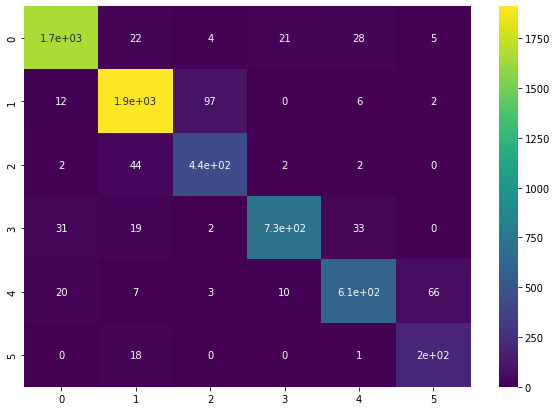

In [57]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(data_test['label'],y_predicted),annot=True,cmap='viridis')
plt.show()

In [68]:
texts = input(str('input the text'))

x_val = tokenizer(
    text=texts,
    add_special_tokens=True,
    max_length=70,
    truncation=True,
    padding='max_length', 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True) 
validation = model.predict({'input_ids':x_val['input_ids'],'attention_mask':x_val['attention_mask']})*100
validation

input the textShe is looking pretty today.


array([[18.390993 , 98.55061  , 61.9093   ,  4.304898 ,  2.8618722,
        19.674965 ]], dtype=float32)

In [69]:
for key, value in zip(encoded_dict.keys(),validation[0]):
    print(key,value)

sadness 18.390993
joy 98.55061
love 61.9093
anger 4.304898
fear 2.8618722
surprise 19.674965
